In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pmdarima as pm
import itertools
import scipy.stats
import seaborn as sns
from scipy import stats
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots  import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA

# Data

### Data Load

In [2]:
gold_url = 'https://raw.githubusercontent.com/SLCFLAB/DL-Forecasting/main/DL/day1/data/gold.csv' 
silver_url = 'https://raw.githubusercontent.com/SLCFLAB/DL-Forecasting/main/DL/day1/data/silver.csv' 
platinum_url = 'https://raw.githubusercontent.com/SLCFLAB/DL-Forecasting/main/DL/day1/data/platinum.csv' 
gold = pd.read_csv(gold_url, index_col=0)
silver = pd.read_csv(silver_url, index_col=0)
platinum = pd.read_csv(platinum_url, index_col=0)

In [3]:
price = gold.set_index(keys = 'Date')
diff = price.diff().dropna()

### Data describe

In [4]:
gold

,Date,Price
0,2017-01-03,1162.0
1,2017-01-04,1165.3
2,2017-01-05,1181.3
3,2017-01-06,1173.4
4,2017-01-09,1184.9
...,...,...
1285,2021-12-27,1808.8
1286,2021-12-28,1810.9
1287,2021-12-29,1805.8
1288,2021-12-30,1814.1


In [5]:
price

,Price
Date,
2017-01-03,1162.0
2017-01-04,1165.3
2017-01-05,1181.3
2017-01-06,1173.4
2017-01-09,1184.9
...,...
2021-12-27,1808.8
2021-12-28,1810.9
2021-12-29,1805.8


In [6]:
gold.isna().sum()

Date     0
Price    0
dtype: int64

In [7]:
gold.describe()

,Price
count,1290.000000
mean,1501.741550
std,254.202298
min,1162.000000
25%,1278.525000
50%,1411.600000
75%,1774.575000
max,2069.400000


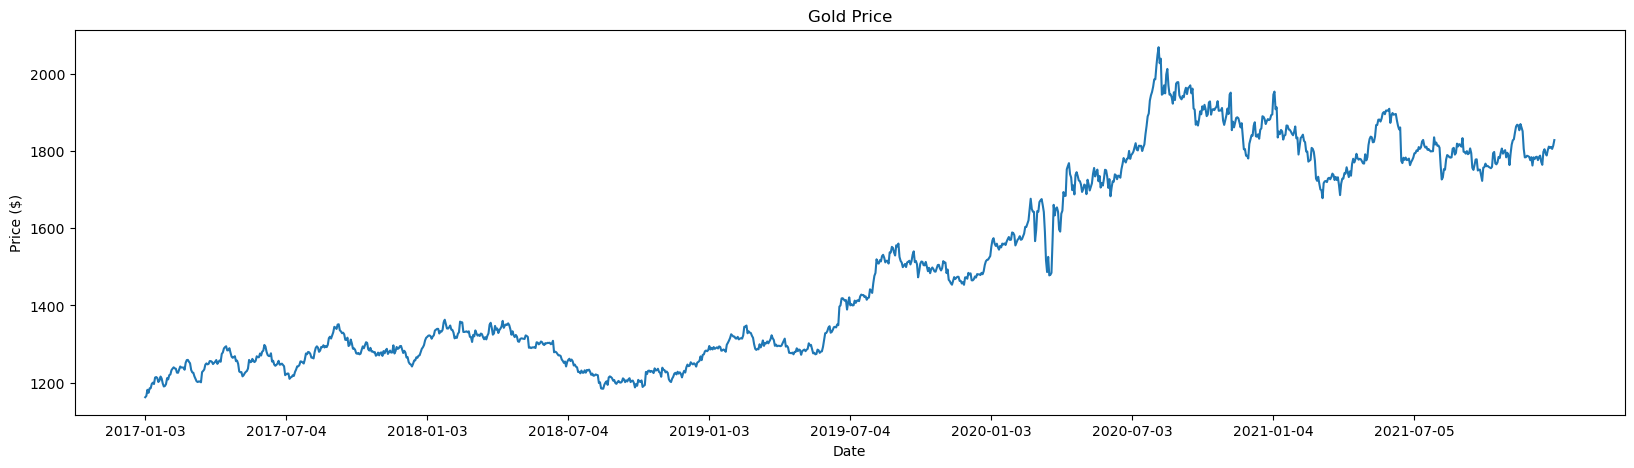

In [8]:
fig, ax = plt.subplots(figsize = (20,5))

ax.plot(price)
ax.set_title('Gold Price')
ax.set_xlabel('Date')
ax.set_ylabel('Price ($)')

total_len = gold.shape[0]
ax.set_xticks(np.arange(0,total_len, 129))


plt.show()

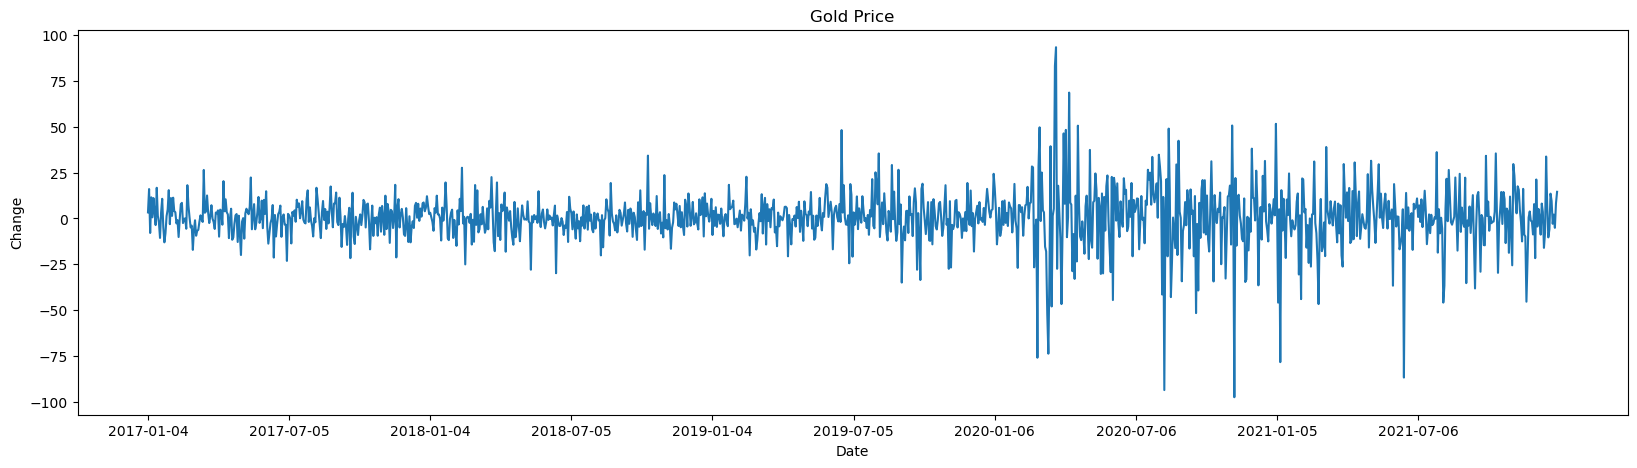

In [9]:
fig, ax = plt.subplots(figsize = (20,5))

ax.plot(diff)
ax.set_title('Gold Price')
ax.set_xlabel('Date')
ax.set_ylabel('Change')

total_len = gold.shape[0]
ax.set_xticks(np.arange(0,total_len, 129))


plt.show()

# Decomposition

### Box-Cox transformation

In [10]:
x = gold['Price'].to_numpy()
y, lambda_optimal = stats.boxcox(x)
print(lambda_optimal)

-1.6225793223320675


<AxesSubplot:ylabel='Density'>

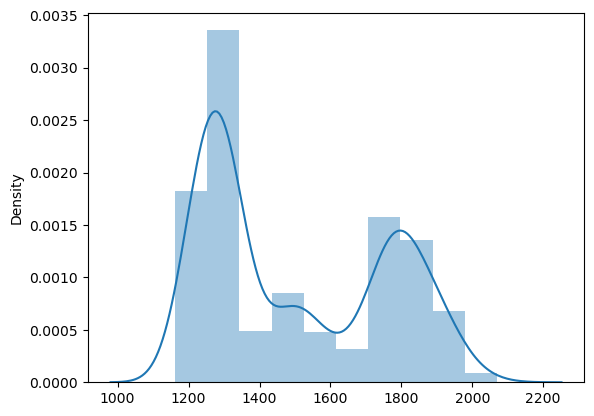

In [11]:
sns.distplot(x, hist=True)

<AxesSubplot:ylabel='Density'>

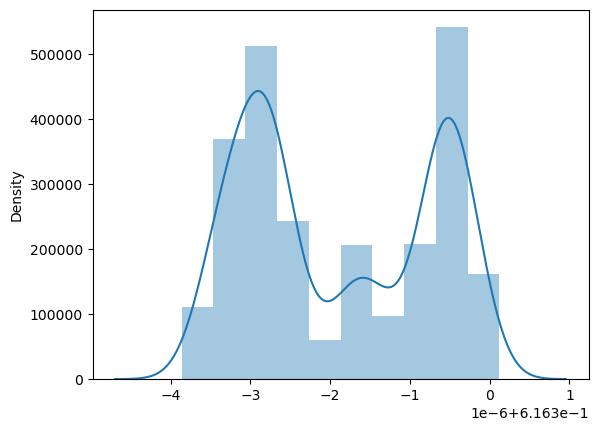

In [12]:
sns.distplot(y, hist=True)

### Moving average

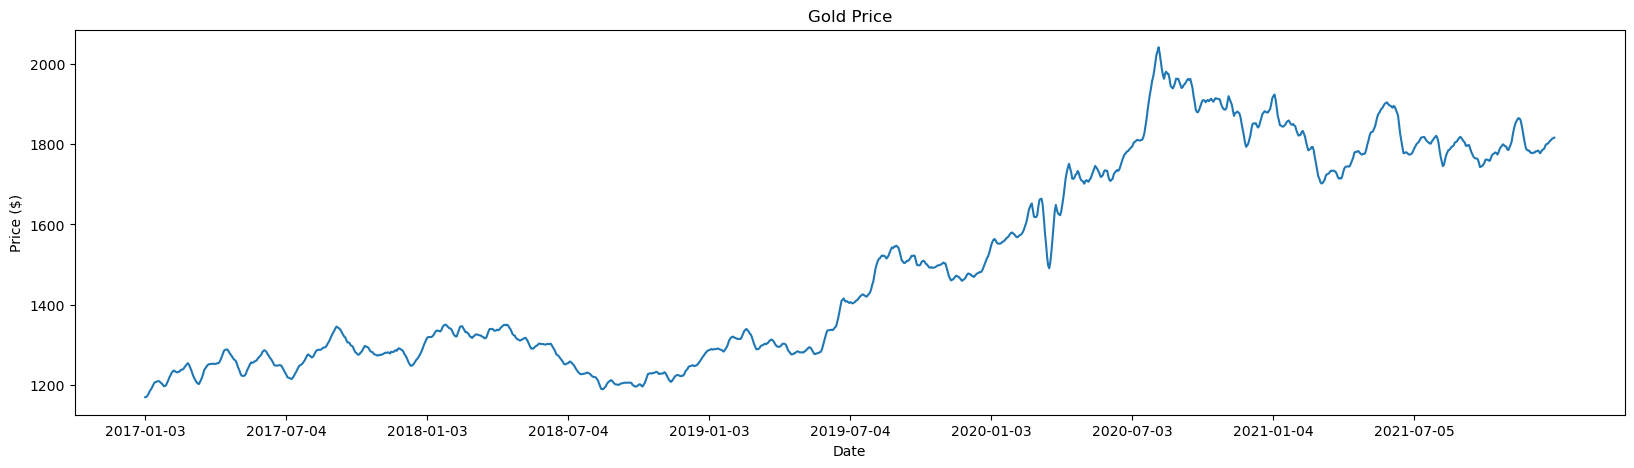

In [13]:
mas = []

for i in range(gold.shape[0]):
    if i >1:
        ma = np.array(gold['Price'][i-2:i+3]).mean()
        mas.append(ma)
    else:
        ma = np.array(gold['Price'][0:i+3]).mean()
        mas.append(ma)

fig, ax = plt.subplots(figsize = (20,5))

ax.plot(gold['Date'], mas)
ax.set_title('Gold Price')
ax.set_xlabel('Date')
ax.set_ylabel('Price ($)')

total_len = gold.shape[0]
ax.set_xticks(np.arange(0,total_len, 129))


plt.show()    

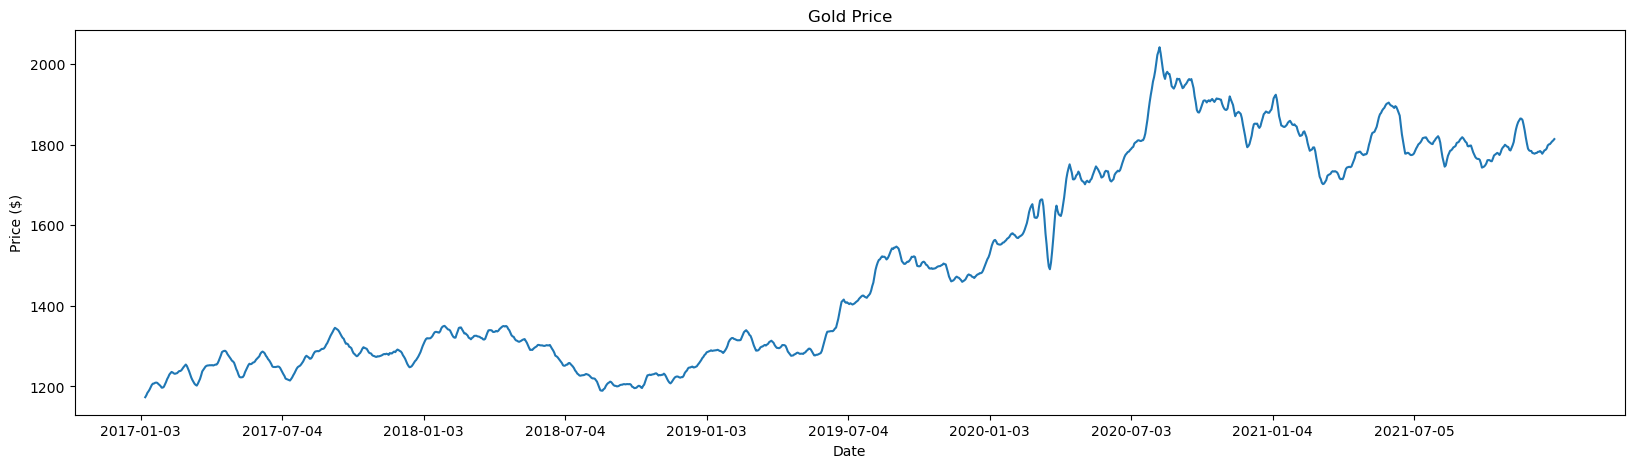

In [14]:
mas = gold['Price'].rolling(5).mean()

fig, ax = plt.subplots(figsize = (20,5))

ax.plot(gold['Date'], mas)
ax.set_title('Gold Price')
ax.set_xlabel('Date')
ax.set_ylabel('Price ($)')

total_len = gold.shape[0]
ax.set_xticks(np.arange(0,total_len, 129))


plt.show()

## Classical Decomposition

### Trend -> Moving average
### Seasonal -> 각 period의 data - trend 평균

<Figure size 2000x600 with 0 Axes>

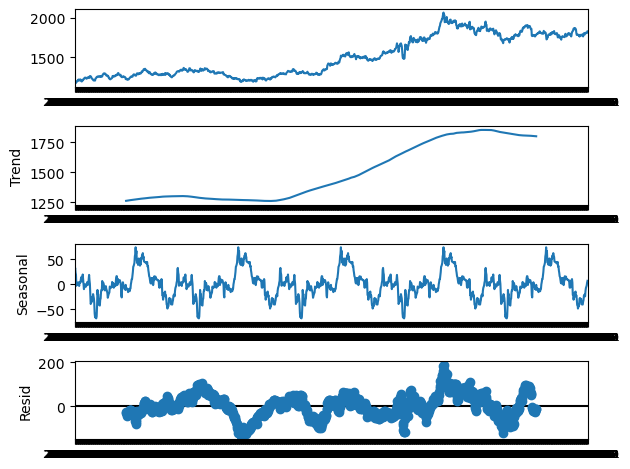

In [15]:
plt.figure(figsize=(20,6))
plt.rc('xtick', labelsize= 8)
gold_decomp = seasonal_decompose(price, model = 'additive',  period = 258)
gold_decomp.plot()
plt.show()

<Figure size 2000x600 with 0 Axes>

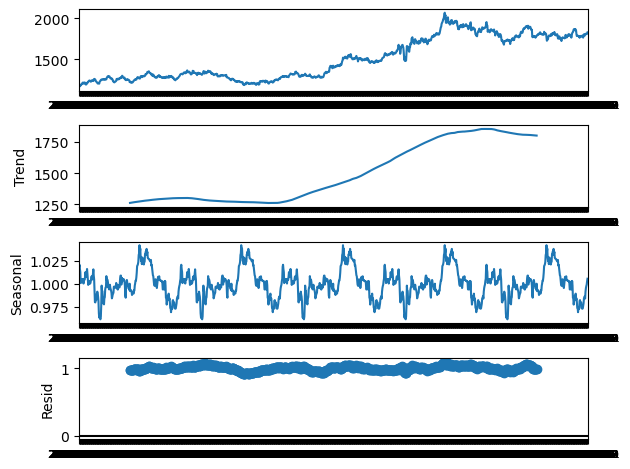

In [16]:
plt.figure(figsize=(20,6))
plt.rc('xtick', labelsize= 8)
gold_decomp = seasonal_decompose(price, model = 'multiplicative',  period = 258)
gold_decomp.plot()
plt.show()

# Stationarity

## Unit root test

In [17]:
def ADF(data):
    
    result = adfuller(data, autolag = 'AIC')
    
    print('-----ADF-----')
    print('ADF Statistic: %f' % result[0])
    print('p-value: %1.10f' % result[1])
    print('Lag: %d' % result[2])
    print('observation: %d' % result[3])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key,value))

In [18]:
print(ADF(price))
print(ADF(diff))

-----ADF-----
ADF Statistic: -0.806442
p-value: 0.8172225725
Lag: 6
observation: 1283
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568
None
-----ADF-----
ADF Statistic: -17.368823
p-value: 0.0000000000
Lag: 5
observation: 1283
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568
None


## ACF / PACF

In [19]:
# reference: https://signature95.tistory.com/24,https://zephyrus1111.tistory.com/135

In [20]:
class autocorrelation:
    def __init__(self, data, lags):
        self.data =  data.reset_index(drop=True).squeeze()
        self.lags =lags
    
    def acf(self):
        acf_vals=[]

        for k in range(self.lags+1):
            mean = self.data.mean()
            sum_var = np.sum(np.square(self.data-mean))
            sum_ac = np.sum((self.data-mean)*(self.data.shift(k)-mean))
            acf_val = sum_ac/sum_var
            acf_vals.append(acf_val)
            print(f"lag at {k}'s ac = ", acf_val)
        return acf_vals
    
    def pacf(self):
        pacf_vals=[]
        acfs = self.acf()
        
        for k in range(self.lags+1):
            if k == 0:
                pacf_val = 1
            else:
                gamma_array = np.array([acfs[k] for k in range(1,k+1)])
                gamma_matrix = []

                for i in range(k):
                    temp = [0]*k
                    temp[i:]=[acfs[j] for j in range(k-i)]
                    gamma_matrix.append(temp)

                gamma_matrix = np.array(gamma_matrix)
                gamma_matrix = gamma_matrix + gamma_matrix.T - np.diag(gamma_matrix.diagonal())
                pacf_val = np.linalg.inv(gamma_matrix).dot(gamma_array)[-1]
            pacf_vals.append(pacf_val)
            print(f"lag at {k}'s pac = ", pacf_val)
        return pacf_vals
    
    def acf_plot(self):
        acfs = self.acf()
        scatter = pd.DataFrame()
        scatter['lags'] = [i for i in range(1,self.lags+1)]
        scatter['autocorrelation'] = acfs[1:]

        fig = plt.figure(figsize=(8,5))
        fig.set_facecolor('white')

        x = range(self.lags+1)
        markers, stemlines, baseline = plt.stem(x, acfs, use_line_collection= True)
        markers.set_color('blue')
        stemlines.set_linestyle('-')
        stemlines.set_color('blue')
        baseline.set_visible(True)

        n = self.data.shape[0]
        upper_limit=[]
        lower_limit=[]
        for k in x:
            if k==0 :
                upper_limit.append(0)
                lower_limit.append(0)
            else:
                term1 = np.sqrt((1+2*np.sum(np.square(acfs[1:k+1])))/n)
                upper_limit.append(1.96*term1)
                lower_limit.append(-1.96*term1)

        plt.fill_between(x, lower_limit, upper_limit, alpha=0.5)
        plt.scatter(x=scatter['lags'], y=scatter['autocorrelation'], edgecolors = 'red', linewidth=1,s=200, alpha=0.5)
        plt.show()

    def pacf_plot(self):
        pacfs = self.pacf()
        scatter = pd.DataFrame()
        scatter['lags'] = [i for i in range(1,self.lags+1)]
        scatter['autocorrelation'] = pacfs[1:]

        fig = plt.figure(figsize=(8,5))
        fig.set_facecolor('white')

        x = range(self.lags+1)
        markers, stemlines, baseline = plt.stem(x, pacfs, use_line_collection= True)
        markers.set_color('blue')
        stemlines.set_linestyle('-')
        stemlines.set_color('blue')
        baseline.set_visible(True)

        n = self.data.shape[0]
        upper_limit=[]
        lower_limit=[]
        for k in x:
            if k==0 :
                upper_limit.append(0)
                lower_limit.append(0)
            else:
                term1 = np.sqrt((1+2*np.sum(np.square(pacfs[1:k+1])))/n)
                upper_limit.append(1.96*term1)
                lower_limit.append(-1.96*term1)

        plt.fill_between(x, lower_limit, upper_limit, alpha=0.5)
        plt.scatter(x=scatter['lags'], y=scatter['autocorrelation'], edgecolors = 'red', linewidth=1,s=200, alpha=0.5)
        plt.show() 

In [21]:
def acf_plot(data, lags):
    dat = data.reset_index(drop=True)
    df = dat.squeeze()
    for i in range(lags+1):
        print(f"lag at {i}'s ac = ", round(df.autocorr(lag=i),2))
    scatter = pd.DataFrame()
    scatter['lags'] = [i for i in range(1,lags+1)]
    scatter['autocorrelation'] = [df.autocorr(lag=i) for i in range(1,lags+1)]
    fig = plot_acf(df, lags=lags)
    plt.scatter(x=scatter['lags'], y=scatter['autocorrelation'], edgecolors = 'red', linewidth=1,s=200, alpha=0.5)
    plt.show()
    
def pacf_plot(data, lags):
    for i in range(lags+1):
        print(f"lag at {i}'s pac = ", round(pacf(data, alpha=.05)[0][i],2))
    scatter = pd.DataFrame()
    scatter['lags'] = [i for i in range(1,lags+1)]
    scatter['Partial autocorrelation'] = [pacf(data, alpha=.05)[0][i] for i in range(1,lags+1)]
    fig = plot_pacf(data, lags=lags)
    plt.scatter(x=scatter['lags'], y=scatter['Partial autocorrelation'], edgecolors = 'red', linewidth=1,s=200, alpha=0.5)
    plt.show()

In [22]:
price_ac = autocorrelation(price,20)

lag at 0's ac =  1.0
lag at 1's ac =  0.9970052898181241
lag at 2's ac =  0.9941128385149992
lag at 3's ac =  0.9912562406071274
lag at 4's ac =  0.9883636969031573
lag at 5's ac =  0.9857785772637923
lag at 6's ac =  0.983309853245613
lag at 7's ac =  0.9812255102554313
lag at 8's ac =  0.9792924767942357
lag at 9's ac =  0.9772788575390086
lag at 10's ac =  0.9751658327619603
lag at 11's ac =  0.9730899202978928
lag at 12's ac =  0.9710063097475291
lag at 13's ac =  0.9686811976204391
lag at 14's ac =  0.9662049056034089
lag at 15's ac =  0.9638986133425929
lag at 16's ac =  0.9616325057086221
lag at 17's ac =  0.9594252823454885
lag at 18's ac =  0.9572937328760516
lag at 19's ac =  0.9553219034923899
lag at 20's ac =  0.9534649126002019


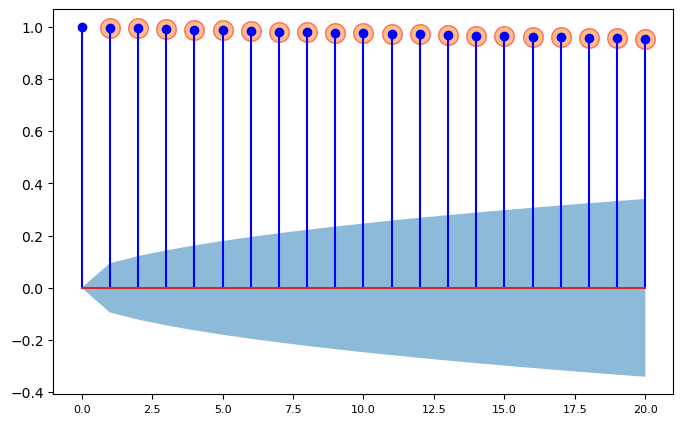

In [23]:
price_ac.acf_plot()

lag at 0's ac =  1.0
lag at 1's ac =  0.9970052898181241
lag at 2's ac =  0.9941128385149992
lag at 3's ac =  0.9912562406071274
lag at 4's ac =  0.9883636969031573
lag at 5's ac =  0.9857785772637923
lag at 6's ac =  0.983309853245613
lag at 7's ac =  0.9812255102554313
lag at 8's ac =  0.9792924767942357
lag at 9's ac =  0.9772788575390086
lag at 10's ac =  0.9751658327619603
lag at 11's ac =  0.9730899202978928
lag at 12's ac =  0.9710063097475291
lag at 13's ac =  0.9686811976204391
lag at 14's ac =  0.9662049056034089
lag at 15's ac =  0.9638986133425929
lag at 16's ac =  0.9616325057086221
lag at 17's ac =  0.9594252823454885
lag at 18's ac =  0.9572937328760516
lag at 19's ac =  0.9553219034923899
lag at 20's ac =  0.9534649126002019
lag at 0's pac =  1
lag at 1's pac =  0.9970052898181241
lag at 2's pac =  0.015599253787655698
lag at 3's pac =  0.004837203726509642
lag at 4's pac =  -0.0072370267064454374
lag at 5's pac =  0.04980197911018536
lag at 6's pac =  0.019880408858967

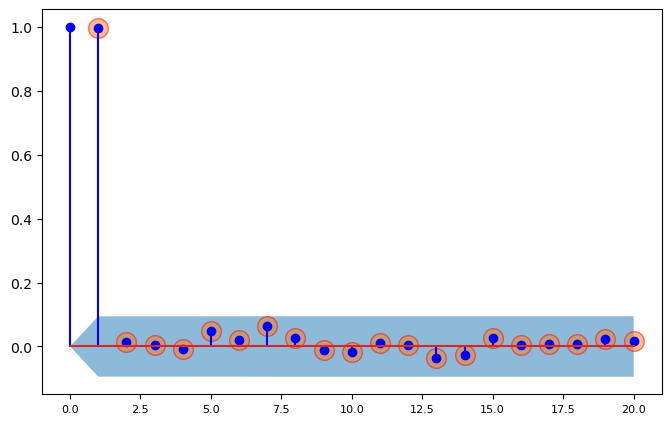

In [24]:
price_ac.pacf_plot()

lag at 0's ac =  1.0
lag at 1's ac =  1.0
lag at 2's ac =  1.0
lag at 3's ac =  1.0
lag at 4's ac =  0.99
lag at 5's ac =  0.99
lag at 6's ac =  0.99
lag at 7's ac =  0.99
lag at 8's ac =  0.99
lag at 9's ac =  0.99
lag at 10's ac =  0.99
lag at 11's ac =  0.99
lag at 12's ac =  0.98
lag at 13's ac =  0.98
lag at 14's ac =  0.98
lag at 15's ac =  0.98
lag at 16's ac =  0.98
lag at 17's ac =  0.98
lag at 18's ac =  0.98
lag at 19's ac =  0.98
lag at 20's ac =  0.98


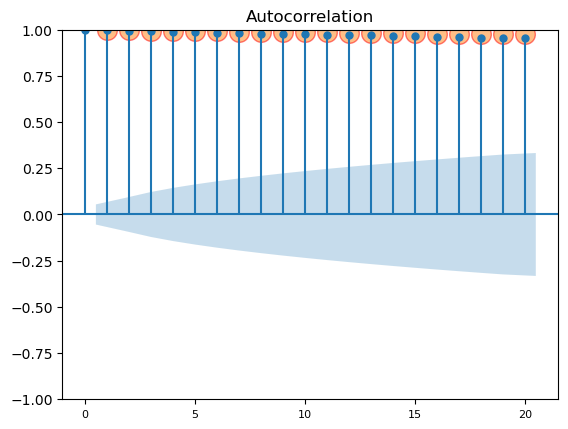

In [25]:
acf_plot(price, 20)

lag at 0's pac =  1.0
lag at 1's pac =  1.0
lag at 2's pac =  0.02
lag at 3's pac =  0.01
lag at 4's pac =  -0.01
lag at 5's pac =  0.07
lag at 6's pac =  0.03
lag at 7's pac =  0.09
lag at 8's pac =  0.04
lag at 9's pac =  -0.01
lag at 10's pac =  -0.02
lag at 11's pac =  0.02
lag at 12's pac =  0.01
lag at 13's pac =  -0.05
lag at 14's pac =  -0.04
lag at 15's pac =  0.03
lag at 16's pac =  0.01
lag at 17's pac =  0.01
lag at 18's pac =  0.01
lag at 19's pac =  0.03
lag at 20's pac =  0.02


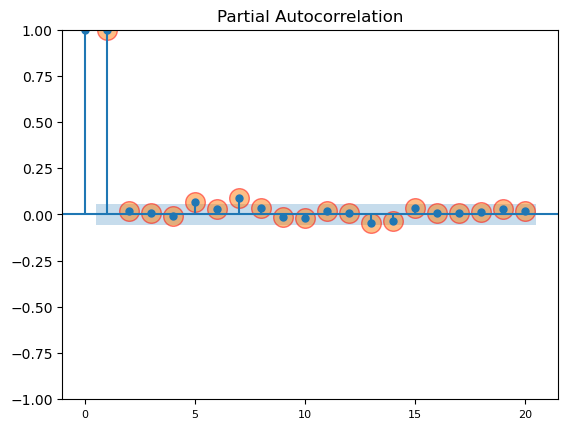

In [26]:
pacf_plot(price, 20)

In [27]:
diff_ac = autocorrelation(diff,20)

lag at 0's ac =  1.0
lag at 1's ac =  -0.0108323573473581
lag at 2's ac =  0.017514923091202575
lag at 3's ac =  -0.00610754276989824
lag at 4's ac =  -0.0772300964567786
lag at 5's ac =  -0.03896200363177116
lag at 6's ac =  -0.09213639949163405
lag at 7's ac =  -0.026820286868924466
lag at 8's ac =  0.011760561392564687
lag at 9's ac =  0.037203248733837985
lag at 10's ac =  -0.002643254002087523
lag at 11's ac =  0.038440978821072024
lag at 12's ac =  0.04946660700209428
lag at 13's ac =  0.02972591209934198
lag at 14's ac =  -0.035033057023081036
lag at 15's ac =  -0.009508614771233626
lag at 16's ac =  -0.045266051379339
lag at 17's ac =  -0.032836091236903925
lag at 18's ac =  -0.04152180179229443
lag at 19's ac =  -0.03492124026408812
lag at 20's ac =  -0.0285540730986546


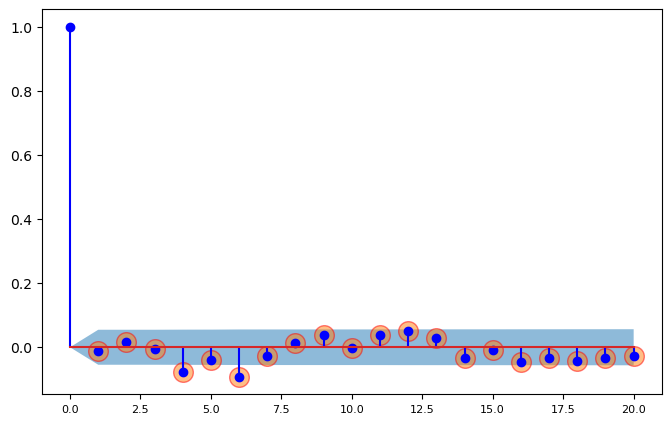

In [28]:
diff_ac.acf_plot()

lag at 0's ac =  1.0
lag at 1's ac =  -0.0108323573473581
lag at 2's ac =  0.017514923091202575
lag at 3's ac =  -0.00610754276989824
lag at 4's ac =  -0.0772300964567786
lag at 5's ac =  -0.03896200363177116
lag at 6's ac =  -0.09213639949163405
lag at 7's ac =  -0.026820286868924466
lag at 8's ac =  0.011760561392564687
lag at 9's ac =  0.037203248733837985
lag at 10's ac =  -0.002643254002087523
lag at 11's ac =  0.038440978821072024
lag at 12's ac =  0.04946660700209428
lag at 13's ac =  0.02972591209934198
lag at 14's ac =  -0.035033057023081036
lag at 15's ac =  -0.009508614771233626
lag at 16's ac =  -0.045266051379339
lag at 17's ac =  -0.032836091236903925
lag at 18's ac =  -0.04152180179229443
lag at 19's ac =  -0.03492124026408812
lag at 20's ac =  -0.0285540730986546
lag at 0's pac =  1
lag at 1's pac =  -0.0108323573473581
lag at 2's pac =  0.017399624796878586
lag at 3's pac =  -0.00573504611899034
lag at 4's pac =  -0.07769549342478521
lag at 5's pac =  -0.04068737166389

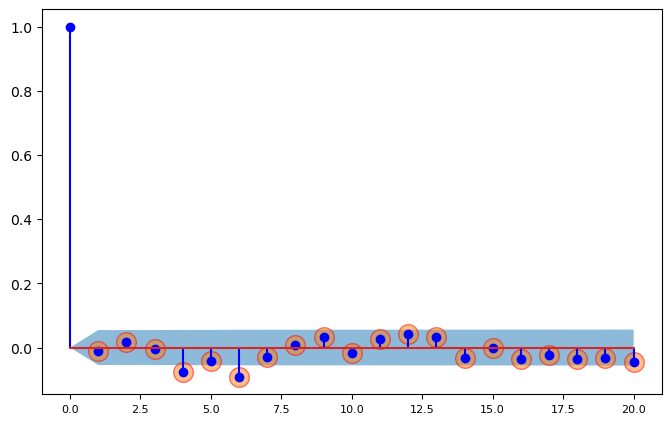

In [29]:
diff_ac.pacf_plot()

lag at 0's ac =  1.0
lag at 1's ac =  -0.01
lag at 2's ac =  0.02
lag at 3's ac =  -0.01
lag at 4's ac =  -0.08
lag at 5's ac =  -0.04
lag at 6's ac =  -0.09
lag at 7's ac =  -0.03
lag at 8's ac =  0.01
lag at 9's ac =  0.04
lag at 10's ac =  -0.0
lag at 11's ac =  0.04
lag at 12's ac =  0.05
lag at 13's ac =  0.03
lag at 14's ac =  -0.04
lag at 15's ac =  -0.01
lag at 16's ac =  -0.05
lag at 17's ac =  -0.03
lag at 18's ac =  -0.04
lag at 19's ac =  -0.04
lag at 20's ac =  -0.03


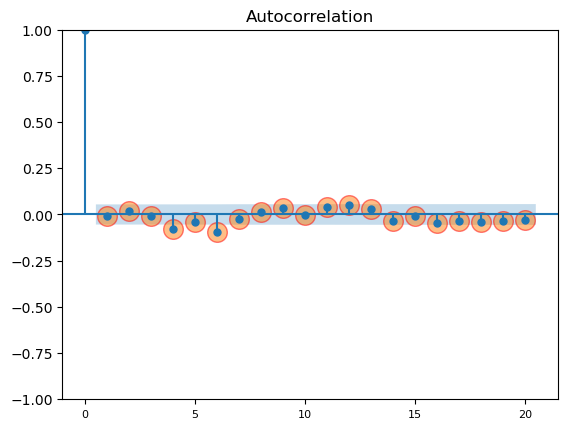

In [30]:
acf_plot(diff, 20)

lag at 0's pac =  1.0
lag at 1's pac =  -0.01
lag at 2's pac =  0.02
lag at 3's pac =  -0.01
lag at 4's pac =  -0.08
lag at 5's pac =  -0.04
lag at 6's pac =  -0.09
lag at 7's pac =  -0.03
lag at 8's pac =  0.01
lag at 9's pac =  0.03
lag at 10's pac =  -0.02
lag at 11's pac =  0.03
lag at 12's pac =  0.04
lag at 13's pac =  0.03
lag at 14's pac =  -0.03
lag at 15's pac =  -0.0
lag at 16's pac =  -0.04
lag at 17's pac =  -0.02
lag at 18's pac =  -0.04
lag at 19's pac =  -0.03
lag at 20's pac =  -0.05


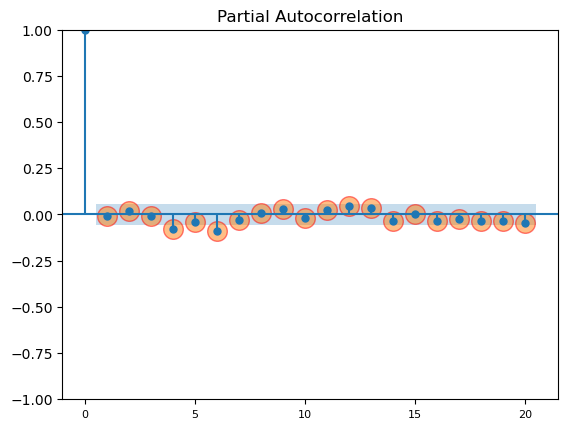

In [31]:
pacf_plot(diff, 20)

# ARIMA

## Train-Test split

In [32]:
forecasting_horizon = int(gold.shape[0]*0.2)
train = price[:-forecasting_horizon]
test = price[-forecasting_horizon:]

## Fitting

In [33]:
p = range(0,6)
d = range(0,3)
q = range(0,6)

orders = list(itertools.product(p,d,q))

In [34]:
#Gold select order
dict_model = {}

for order in orders:
    model = ARIMA(train, order = order)
    model_fit = model.fit()
    dict_model[order] = [model_fit.llf, model_fit.aic, model_fit.bic]
    
information = pd.DataFrame.from_dict(dict_model, orient='index', columns=['llf', 'Aic', 'Bic'])
print('By BIC')
print(information.sort_values(by=['Bic'], ascending =True))

C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._

C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._

C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._

C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autor

C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autor

C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autor

C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autor

C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autor

C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\U

C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._

C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\U

C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\U

By BIC
                   llf           Aic           Bic
(0, 1, 0) -4186.818237   8375.636475   8380.574759
(0, 2, 1) -4185.437423   8374.874847   8384.749475
(2, 1, 3) -4172.195781   8356.391562   8386.021269
(3, 1, 2) -4172.202431   8356.404863   8386.034570
(1, 1, 0) -4186.780252   8377.560504   8387.437073
...                ...           ...           ...
(0, 0, 3) -5820.941513  11651.883026  11676.579296
(0, 0, 4) -5968.049945  11948.099890  11977.735414
(0, 0, 2) -6131.058302  12270.116604  12289.873620
(0, 0, 1) -6398.740105  12803.480210  12818.297972
(0, 0, 0) -7071.464898  14146.929795  14156.808303

[108 rows x 3 columns]


C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [35]:
model_aic = pm.auto_arima(train, information_criteria = 'aic')
model_bic = pm.auto_arima(train, information_criteria = 'bic')

print(model_aic.summary())
print(model_bic.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1032
Model:               SARIMAX(2, 1, 3)   Log Likelihood               -4170.308
Date:                Mon, 04 Sep 2023   AIC                           8354.616
Time:                        15:55:50   BIC                           8389.184
Sample:                             0   HQIC                          8367.735
                               - 1032                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2006      0.107      1.876      0.061      -0.009       0.410
ar.L1          1.6116      0.033     48.502      0.000       1.546       1.677
ar.L2         -0.8931      0.034    -26.435      0.0

## Forecasting

In [36]:
#ARIMA(0,1,0)
arima_errors = []
arima_preds = []
order = (0,1,0)


for i in range(forecasting_horizon) :
    arima_model = ARIMA(price[:-forecasting_horizon+i], order = order)
    arima_model_fit = arima_model.fit()
    arima_pred = arima_model_fit.forecast(steps=1).item()
    arima_error = arima_pred - price.iloc[price.shape[0]-forecasting_horizon+i].item()
    arima_abs_error = abs(arima_error)
    arima_preds.append(arima_pred)
    arima_errors.append(arima_abs_error)

    
arima_abs_errors = np.array(arima_errors)
arima = arima_abs_errors.mean()
print(arima)

C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction

C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction

C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction

C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates

C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates

C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates

C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates

C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction

C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates

C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates

C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates

C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates

C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates

C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates

C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates

C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates

C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates

C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction

C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates

C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates

C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates

C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction

C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates

C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction

C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates

C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates

11.584883720930227


C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction

In [37]:
#Auto-ARIMA
arima_errors1 = []
arima_preds1 = []


for i in range(forecasting_horizon) :
    arima_model1 = pm.auto_arima(price[:-forecasting_horizon+i], max_p = 3, max_q=3, d =1, information_criteria = 'bic')
    arima_pred1 = arima_model1.predict(1).item()
    arima_error1 = arima_pred1 - price.iloc[price.shape[0]-forecasting_horizon+i].item()
    arima_abs_error1 = abs(arima_error1)
    arima_preds1.append(arima_pred1)
    arima_errors1.append(arima_abs_error1)

    
arima_abs_errors1 = np.array(arima_errors1)
arima1 = arima_abs_errors1.mean()
print(arima1)

C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Seungyun\anaconda3\lib\site-pac

C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Seungyun\anaconda3\lib\site-pac

C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Seungyun\anaconda3\lib\site-pac

C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Seungyun\anaconda3\lib\site-pac

C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Seungyun\anaconda3\lib\site-pac

C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Seungyun\anaconda3\lib\site-pac

C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Seungyun\anaconda3\lib\site-pac

C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Seungyun\anaconda3\lib\site-pac

11.554561848557439


C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


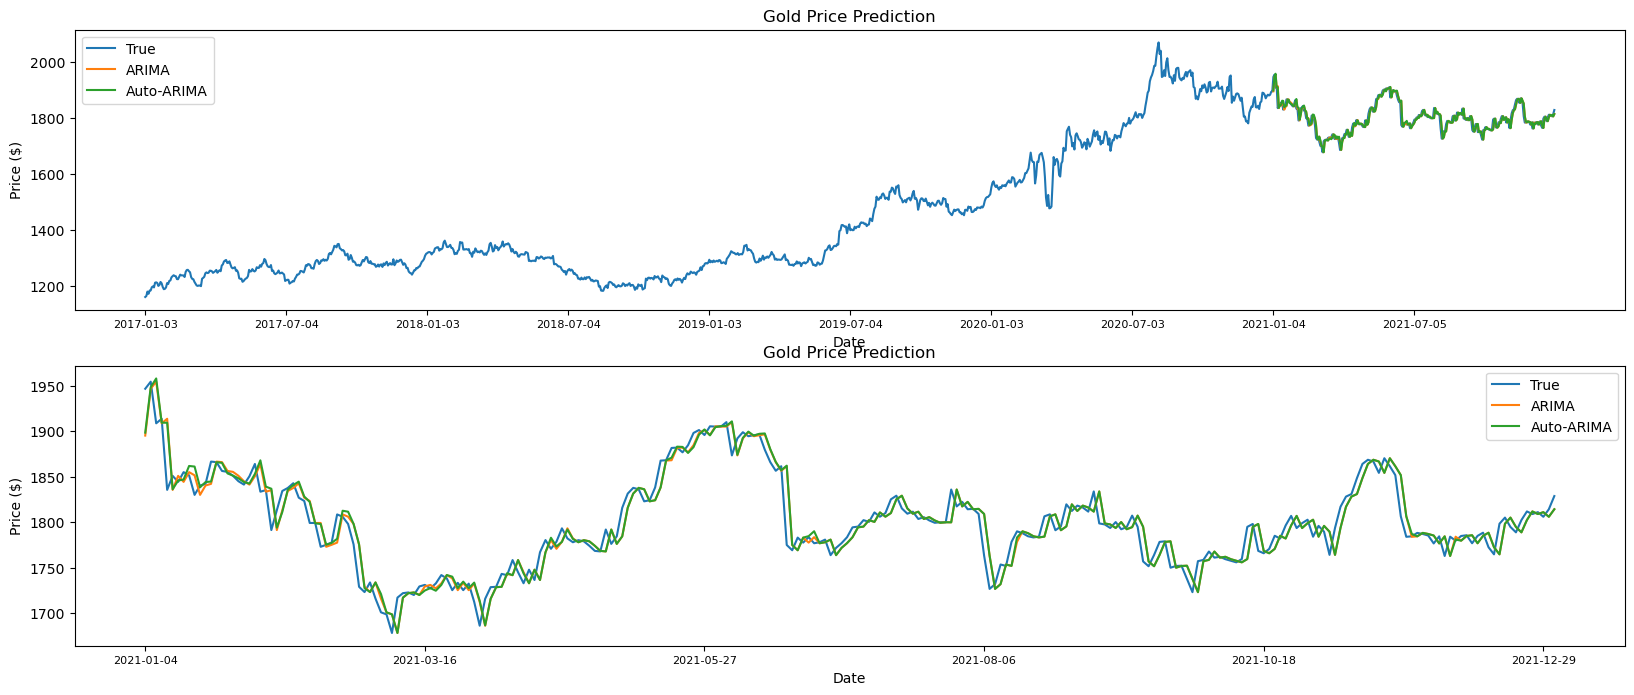

In [38]:
preds = pd.DataFrame(arima_preds, index = gold['Date'][-forecasting_horizon:])
preds1 = pd.DataFrame(arima_preds1, index = gold['Date'][-forecasting_horizon:])

fig, ax = plt.subplots(2,1,figsize = (20,8))
x1 = gold['Date']
x2 = gold['Date'][-forecasting_horizon:]

ax[0].plot(x1, price, label = 'True')
ax[0].plot(x2, preds, label = 'ARIMA')
ax[0].plot(x2, preds1, label = 'Auto-ARIMA')
ax[0].set_title('Gold Price Prediction')
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Price ($)')
ax[0].legend()

ax[1].plot(x2, price[-forecasting_horizon:], label = 'True')
ax[1].plot(x2, preds, label = 'ARIMA')
ax[1].plot(x2, preds1, label = 'Auto-ARIMA')
ax[1].set_title('Gold Price Prediction')
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Price ($)')
ax[1].legend()

total_len = gold.shape[0]
ax[0].set_xticks(np.arange(0,total_len, 129))
ax[1].set_xticks(np.arange(0,forecasting_horizon, int(forecasting_horizon*0.2)))


plt.show()

In [39]:
order = (0,1,0)
arima_model_dms = ARIMA(price[:-forecasting_horizon], order = order)
arima_model_dms_fit = arima_model_dms.fit()
arima_dms_pred = arima_model_dms_fit.forecast(steps=forecasting_horizon)
arima_dms_error = arima_dms_pred - gold['Price'][price.shape[0]-forecasting_horizon:]
arima_dms_abs_error = abs(arima_dms_error)
arima_dms_abs_error = np.array(arima_dms_abs_error)
print(arima_dms_abs_error.mean())

arima_model_dms1 = pm.auto_arima(price[:-forecasting_horizon], max_p = 3, max_q=3, d =1, information_criteria = 'bic')
arima_dms_pred1 = arima_model_dms1.predict(forecasting_horizon)
arima_dms_error1 = arima_dms_pred1 - gold['Price'][price.shape[0]-forecasting_horizon:]
arima_dms_abs_error1 = abs(arima_dms_error1)
arima_dms_abs_error1 = np.array(arima_dms_abs_error1)
arima_dms_abs_error1.mean()

C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction

97.13333333333325


C:\Users\Seungyun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


191.3282780103584

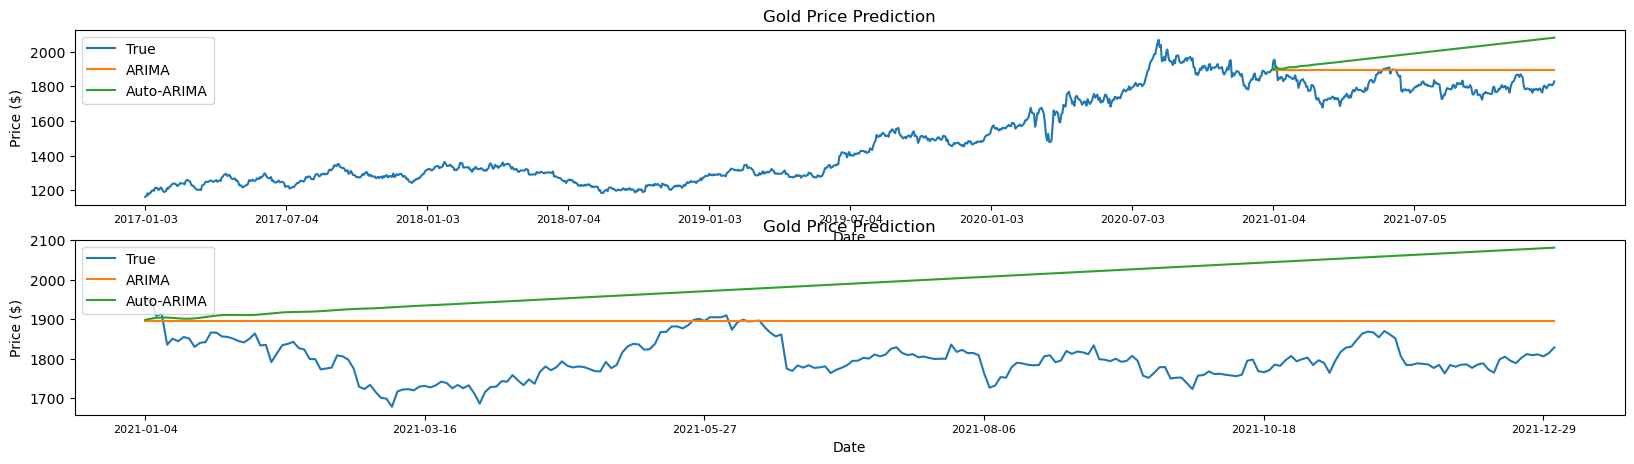

In [40]:
preds_dms= pd.DataFrame(arima_dms_pred.to_numpy(), index = gold['Date'][-forecasting_horizon:])
preds_dms1= pd.DataFrame(arima_dms_pred1.to_numpy(), index = gold['Date'][-forecasting_horizon:])


fig, ax = plt.subplots(2,1,figsize = (20,5))
x1 = gold['Date']
x2 = gold['Date'][-forecasting_horizon:]

ax[0].plot(x1, price, label = 'True')
ax[0].plot(x2, preds_dms, label = 'ARIMA')
ax[0].plot(x2, preds_dms1, label = 'Auto-ARIMA')
ax[0].set_title('Gold Price Prediction')
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Price ($)')
ax[0].legend()

ax[1].plot(x2, price[-forecasting_horizon:], label = 'True')
ax[1].plot(x2, preds_dms, label = 'ARIMA')
ax[1].plot(x2, preds_dms1, label = 'Auto-ARIMA')
ax[1].set_title('Gold Price Prediction')
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Price ($)')
ax[1].legend()

total_len = gold.shape[0]
ax[0].set_xticks(np.arange(0,total_len, 129))
ax[1].set_xticks(np.arange(0,forecasting_horizon, int(forecasting_horizon*0.2)))


plt.show()